In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,  r2_score

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# Data Prep

In [3]:
data = pd.read_csv("merge_2.csv")

In [4]:
cols = ["SentiDate", "LiAdj Close", "ALBAdj Close", 'ALBVolume', 'LiVolume', "Sentiscore"]

In [5]:
data.dropna(inplace=True, subset=cols)

In [6]:
data.columns

Index(['SentiDate', 'Sentiscore', 'ALBDate', 'ALBOpen', 'ALBHigh', 'ALBLow',
       'ALBClose', 'ALBAdj Close', 'ALBVolume', 'ALBUnnamed: 7',
       'ALBUnnamed: 8', 'Source', 'LiDate', 'LiOpen', 'LiHigh', 'LiLow',
       'LiClose', 'LiAdj Close', 'LiVolume'],
      dtype='object')

In [7]:
data = data[cols]
data.head()

,SentiDate,LiAdj Close,ALBAdj Close,ALBVolume,LiVolume,Sentiscore
0,05-03-2024,0.001362,109.400002,19322400,1155143,-0.307199
1,04-03-2024,0.001571,133.199997,4216900,1262621,-0.122088
2,01-03-2024,0.001698,142.800003,3279700,1127246,-0.235303
3,29-02-2024,0.001743,137.850006,4563000,1815600,0.337832
4,28-02-2024,0.001608,132.059998,2733100,2514223,0.887329


In [8]:
data["SentiDate"] = pd.to_datetime(data["SentiDate"], format="%d-%m-%Y")

In [9]:
data = data.sort_values(by='SentiDate')

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
cols = ["LiAdj Close", "ALBAdj Close", 'ALBVolume', 'LiVolume', "Sentiscore"]
data[cols] = scaler.fit_transform(data[cols])

In [12]:
data.head()

,SentiDate,LiAdj Close,ALBAdj Close,ALBVolume,LiVolume,Sentiscore
124,2023-08-21,0.048556,0.866017,0.042901,0.002677,0.948563
123,2023-08-22,0.093176,0.867007,0.047420,0.035980,0.494322
122,2023-08-23,0.075459,0.906795,0.010267,0.025782,0.972807
121,2023-08-24,0.064961,0.895364,0.015294,0.002492,0.532738
120,2023-08-25,0.058399,0.884372,0.041482,0.001829,1.000000


# Training

In [13]:
def train(X, y):
    (
        X_train,
        X_test,
        y_train,
        y_test,
    ) = train_test_split(X, y, test_size=0.3, random_state=3) # 6

    # print out size of subsets
    print("X_train shape: ", X_train.shape)
    print("X_test shape: ", X_test.shape)
    print("y_train shape: ", y_train.shape)
    print("y_test shape: ", y_test.shape)

    model = LinearRegression()
    model.fit(X_train, y_train)

    # print out the coefficients and intercept
    print("Coefficients: ", model.coef_)
    print("Intercept: ", model.intercept_)

    y_pred = model.predict(X_test)
    
    return y_test, y_pred

In [14]:
def train_and_eval(X, y):
    y_test, y_pred = train(X, y)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

## Without Sentiment

In [15]:
# cols = ["LiAdj Close", 'ALBVolume', 'LiVolume']
cols = ["LiAdj Close", 'ALBVolume', 'LiVolume']
X_without_senti = data[cols]
y_without_senti = data["ALBAdj Close"]

mse_no_sen, r2_no_sen = train_and_eval(X_without_senti, y_without_senti)
print("MSE without sentiment: ", mse_no_sen)
print("R^2 without sentiment: ", r2_no_sen)

X_train shape:  (88, 3)
X_test shape:  (39, 3)
y_train shape:  (88,)
y_test shape:  (39,)
Coefficients:  [-0.61701639 -1.30087905  0.01389677]
Intercept:  0.625267441550753
MSE without sentiment:  0.08006756583373088
R^2 without sentiment:  0.024239036977556028


## With Sentiment

In [16]:
X_with_senti = data[cols + ["Sentiscore"]]
y_with_senti = data["ALBAdj Close"]

mse_sen, r2_sen = train_and_eval(X_with_senti, y_with_senti)
print("MSE with sentiment: ", mse_sen)
print("R^2 with sentiment: ", r2_sen)

X_train shape:  (88, 4)
X_test shape:  (39, 4)
y_train shape:  (88,)
y_test shape:  (39,)
Coefficients:  [-0.62052272 -1.24042433  0.02599556  0.05446632]
Intercept:  0.5868921064322785
MSE with sentiment:  0.07730251833715981
R^2 with sentiment:  0.05793589512433328


# Interpret

## MSE gets lower

In [17]:
diff = mse_no_sen - mse_sen
print("MSE goes down after considering sentiment ? ", mse_no_sen > mse_sen)
print("Difference in MSE: ", mse_no_sen - mse_sen)

MSE goes down after considering sentiment ?  True
Difference in MSE:  0.0027650474965710686


## Coefficients

<Axes: xlabel='SentiDate'>

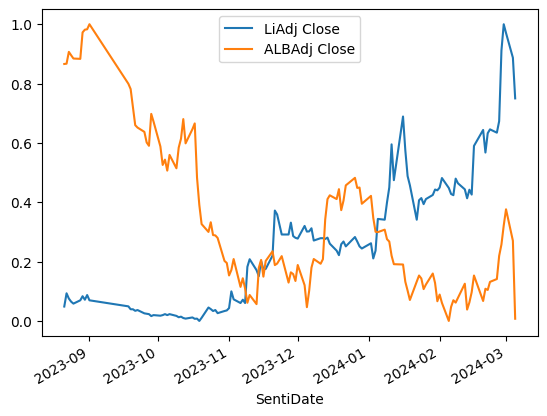

In [18]:
data.plot(x="SentiDate", y=["LiAdj Close", "ALBAdj Close"])

<Axes: xlabel='SentiDate'>

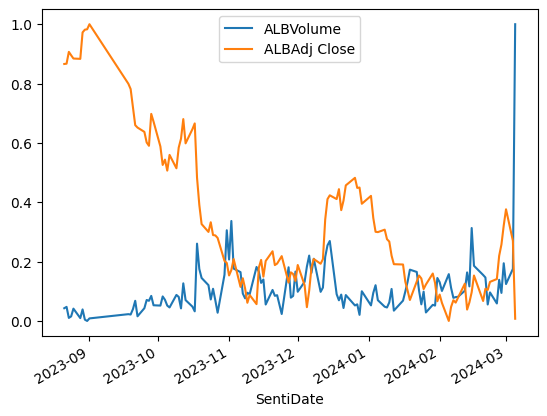

In [19]:
data.plot(x="SentiDate", y=["ALBVolume", "ALBAdj Close"]) 

<Axes: xlabel='SentiDate'>

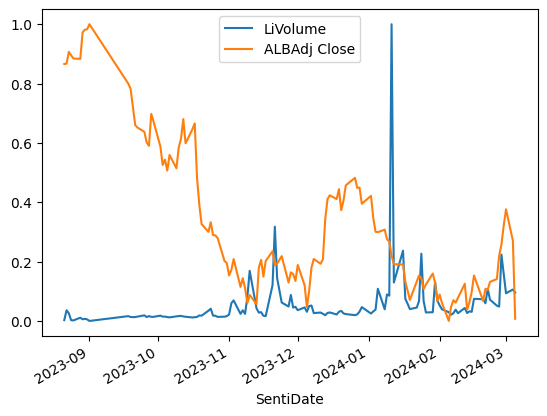

In [20]:
data.plot(x="SentiDate", y=["LiVolume", "ALBAdj Close"])

<Axes: xlabel='SentiDate'>

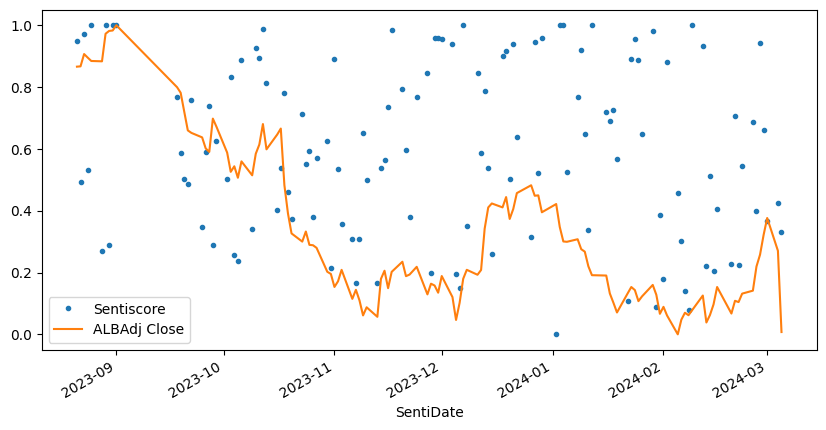

In [21]:
data.plot(x="SentiDate", y=["Sentiscore", "ALBAdj Close"], style=['.', '-'], figsize=(10, 5))

In [22]:
import statsmodels.api as sm

X_without_senti_sm = sm.add_constant(X_without_senti)
model_without_senti = sm.OLS(y_without_senti, X_without_senti_sm).fit()
print(model_without_senti.summary())

                            OLS Regression Results                            
Dep. Variable:           ALBAdj Close   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     25.76
Date:                Sat, 16 Mar 2024   Prob (F-statistic):           5.32e-13
Time:                        14:58:55   Log-Likelihood:                 22.259
No. Observations:                 127   AIC:                            -36.52
Df Residuals:                     123   BIC:                            -25.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5589      0.031     17.743      

In [23]:
X_with_senti_sm = sm.add_constant(X_with_senti)
model_with_senti = sm.OLS(y_with_senti, X_with_senti_sm).fit()
print(model_with_senti.summary())

                            OLS Regression Results                            
Dep. Variable:           ALBAdj Close   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     20.16
Date:                Sat, 16 Mar 2024   Prob (F-statistic):           9.14e-13
Time:                        14:59:10   Log-Likelihood:                 23.519
No. Observations:                 127   AIC:                            -37.04
Df Residuals:                     122   BIC:                            -22.82
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4886      0.055      8.916      